# Functions

In [2]:
# imported libraries
# ********************************************************************************************
import csv
import pandas as pd
import scipy.stats
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import numpy as np
from statistics import median, mean
import seaborn as sns

# ********************************************************************************************
# Mapping Human IDs to Population Codes
# ********************************************************************************************

# Main Path Function
    #  Input: a file of raw, unparsed human profile data with correspondign human IDs
    #  Output: a dictionary where the key is the human ID and the value is the corresponding population code
def get_humanID_to_PopulationCode(file_in):

    # Open the CSV file with the open() function
    # This returns a file object that you can use to read the file
    with open(file_in) as csvfile:
        
        # Use the csv.reader() function to read the file
        # This returns an iterable object that you can loop over
        data = csv.reader(csvfile)

        rawRowDataAsList = []

        # Loop over the rows in the file
        for row in data:
            rawRowDataAsList.append(row)

        humanIDInfoHeader = rawRowDataAsList[0][0].split("\t")
        del rawRowDataAsList[0]

        humanInfoParsed = []

        for rawHumanInfo in rawRowDataAsList:
            singleHumanInfoParsed = rawHumanInfo[0].split("\t")
            humanInfoParsed.append(singleHumanInfoParsed)

        humanID_to_PopulationCode = {}

        for humanInfo in humanInfoParsed:
            humanID = humanInfo[0]
            populationCode = humanInfo[3]
            humanID_to_PopulationCode[humanID] = populationCode

    return humanID_to_PopulationCode

# ********************************************************************************************
# Gene data parsing and organization
# ********************************************************************************************

# Helper Function
    # Input: a list that contains raw SNPs for a number of HumanIDs
    # Output: a list that contains SNPs for number of HumanIDs that have been converted based on genotype 
        # 0 = homozygous recessive
        # 1 = heterozygous
        # 2 = homozygous dominant
def convert_rawSNPData_to_Standard(snp_list):

    standard_snp_list = []

    for humanGene in snp_list:
        if humanGene == "0|0":
            standard_snp_list.append(0)
        elif humanGene == "1|0" or humanGene == "0|1":
            standard_snp_list.append(1)
        elif humanGene == "1|1":
            standard_snp_list.append(2)

    return standard_snp_list

# Main Path Function
    # Input: a file containing the raw gene data for numerous SNPs
    # Output: 
        # humanIDs -> a list of human IDs for the SNPS
        # geneData -> a list of raw, unparsed SNP gene data for the human IDs
def get_humanIDsList_SNPsList_control(file_in):

    # Open the CSV file with the open() function
    # This returns a file object that you can use to read the file
    with open(file_in) as csvfile:

        # Use the csv.reader() function to read the file
        # This returns an iterable object that you can loop over
        data = csv.reader(csvfile)

        rawRowDataAsList = []

        # Loop over the rows in the file
        for row in data:
            rawRowDataAsList.append(row)

        # HUMAN IDs 
        rawHumanIDs = rawRowDataAsList[19][0].split("\t")
        # print('rawHumanIDs\n', rawHumanIDs)
        humanIDs = rawHumanIDs[9: len(rawHumanIDs)-1]
        # print('humanIDs\n', humanIDs)

        # GENE DATA
        rawSNPData = rawRowDataAsList[20: len(rawRowDataAsList)-1]
        # print('rawGeneData\n', rawGeneData)

        geneData = [] 
        for row in rawSNPData:
            rawGeneRowParsed = row[0].split("\t")
            snp_list = rawGeneRowParsed[9:len(rawGeneRowParsed)-1]
            standard_snp_list = convert_rawSNPData_to_Standard(snp_list)
            geneData.append(standard_snp_list)
        # print("geneData\n", geneData)

    return (humanIDs, geneData)

# ********************************************************************************************
# Merge genotypes with population codes by corresponding human IDs
# ********************************************************************************************
# Helper Function
    # Input: a dictionary of population codes to genotypes that have not be summed yet for a single snp
    # Output: a dictionary of the summed genotypes for the corresponding population code for a single snp --> population code : [recessive, heterozygous, dominant]
def get_populationCode_to_geneFrequencies_for_single_snp(snp):
    populationCode_to_geneFrequencies = {}

    for populationCode_genotype in snp:

        populationCode = populationCode_genotype[0]
        genotype = populationCode_genotype[1]

        if genotype == 0:
            genotypeList = [1, 0, 0]
        elif genotype == 1:
            genotypeList = [0, 1, 0]
        elif genotype == 2:
            genotypeList = [0, 0, 1]

        if populationCode not in populationCode_to_geneFrequencies.keys():
            populationCode_to_geneFrequencies[populationCode] = genotypeList

        elif populationCode in populationCode_to_geneFrequencies.keys():
            currentGenotypeList = populationCode_to_geneFrequencies.get(populationCode)

            # Use a list comprehension to add the elements from the two lists together
            totalGenotypeList = [x + y for x, y in zip(currentGenotypeList, genotypeList)]

            populationCode_to_geneFrequencies[populationCode] = totalGenotypeList

    return populationCode_to_geneFrequencies

# Main Path Function
    # Input: 
        # humanIDs_control --> list of human IDs
        # SNPData_control --> list of SNP data
        # humanID_to_PopulationCode_sample --> a dictionary mapping human IDs to population codes
    # Output: a dataframe where the column hears are the population code of the correspondign human ID and the row headers are the SNP
def create_df_of_genotypes_populationCodes(humanIDs_control, SNPData_control, humanID_to_PopulationCode_sample):
    populationCodes = []
    for humanID in humanIDs_control:
        populationCode = humanID_to_PopulationCode_sample.get(humanID)
        populationCodes.append(populationCode)

    # Create the dataframe with specified column names
    df = pd.DataFrame(SNPData_control, columns=populationCodes)

    return df

# Main Path Function 
    # Input: a dataframe of snps with columns = population codes, rows = snps, values = genotypes
    # Output: a list of lists --> where each outer list is a snp and the inner list is [population code, genotype] that are NOT summed
def get_snps_populationCode_to_genotype_control(df):
    snps_populationCode_to_genotype_control = []

    # Loop through every row in the dataframe
    # i = 0
    for index, row in df.iterrows():
        # Loop through every column name in the dataframe
        # j = 0
        snp_populationCode_to_genotype = []
        for x in range(len(df.columns)):
            # Print the values in each column
            # print(row[x])
        # for col in df.columns:
            # Print the values in each column
            # print(type())
            # populationCode_to_genotype[df.columns[x]] = row[x]
            snp_populationCode_to_genotype.append([df.columns[x], row[x]])
        #     print("--", i, j, "Population Code:", df.columns[x], "Genotype:", row[x], "...END...")
        #     j += 1
        # i += 1
        snps_populationCode_to_genotype_control.append(snp_populationCode_to_genotype)

    # print("populationCode_to_genotype_control\n", snps_populationCode_to_genotype_control)
    return snps_populationCode_to_genotype_control

# Main Path function
    # Input: a list of lists --> where each outer list is a snp and the inner list is [population code, genotype] that are NOT summed
    # Output: a list of dictionaries where each index in the list is a snp and each dictionary's key is a population code and corresponding value is a list of the summed [recessive, heterozygous, dominant]
def get_snps_list_populationCode_to_geneFrequencies_control(snps_populationCode_to_genotype_control):
    snps_list_populationCode_to_geneFrequencies_control = []

    for snp in snps_populationCode_to_genotype_control:

        populationCode_to_geneFrequencies = get_populationCode_to_geneFrequencies_for_single_snp(snp)
        snps_list_populationCode_to_geneFrequencies_control.append(populationCode_to_geneFrequencies)

    return snps_list_populationCode_to_geneFrequencies_control

# ********************************************************************************************
# Perform Chi-square Statistical test 
# ********************************************************************************************

# Helper Function
    # Input: a dictionary of population codes to summed genetype frequencies
    # Output: a dataframe where the columen headers are the genotypes and the row headers are the population codes
def create_df_from_populationCode_to_geneFrequencies(populationCode_to_geneFrequencies):
    
    geneFrequenciesList = []
    populationCodesList = []
    for key, value in populationCode_to_geneFrequencies.items():
        geneFrequenciesList.append(value)
        populationCodesList.append(key)

    # Create a list of column names
    columns = ['Reference', 'Heterozygous', 'ALT']

    # Convert the list of lists to a DataFrame
    df = pd.DataFrame(geneFrequenciesList, columns=columns, index=populationCodesList)

    # Print the resulting DataFrame
    # print(df)

    return df

# Helper Function
    # Input: a dataframe of summed genotypes and population codes
    # Output: 
        # [chi2, p] --> a list of the chi square stat and the p value
        #  -1 --> no variance in snp
def perform_chi_square_test(df):
    # Perform the chi-square test
    try: 
        chi2, p, dof, expected = chi2_contingency(df)
        return [chi2, p]
    except:
        return -1

# Main Path Function
    # Input: a list of dictionaries where each index in the list is a snp and each dictionary's key is a population code and corresponding value is a list of the summed [reference, heterozygous, ALT]
    # Output: a list of chi2 values or -1 if chi2 could not be calculated
def get_chi2_p_forEachSNP_list(snps_list_populationCode_to_geneFrequencies_control):

    chi2_p_list = []

    for snp in snps_list_populationCode_to_geneFrequencies_control:

        df = create_df_from_populationCode_to_geneFrequencies(snp)
        # print(df)
        chi2_p = perform_chi_square_test(df)
        chi2_p_list.append(chi2_p)
    
    return chi2_p_list

# Main Path Function 
    # Input: 
        # snps_list_populationCode_to_geneFrequencies_control --> a list of dictionaries where each index in the list is a snp and each dictionary's key is a population code and corresponding value is a list of the summed [reference, heterozygous, ALT]
        # chi2_p_list_raw_control --> a list of chi2 values or -1 if chi2 could not be calculated
    # Output: a list of ALT frequencies for the corresponding snp in the list of chi square scores
def get_ALT_frequency_for_snps(snps_list_populationCode_to_geneFrequencies_control, chi2_p_list_raw_control):

    alt_frequency_list_raw = []
    for snp in snps_list_populationCode_to_geneFrequencies_control:

        alt_sum = 0
        genotypes_sum = 0

        for key, value in snp.items():

            genotypes_sum += sum(value)*2

            alt = value[1]
            alt2 = value[2]*2
            alt_sum += (alt+alt2)

        alt_frequency = alt_sum/genotypes_sum
        alt_frequency_list_raw.append(alt_frequency)

    alt_frequency_list = []
    for i in range(len(chi2_p_list_raw_control)-1):

        if chi2_p_list_raw_control[i] != -1:

            alt_frequency_list.append(alt_frequency_list_raw[i])

    return alt_frequency_list

# ********************************************************************************************
# Additional Analysis from Chi-square Statistical test 
# ********************************************************************************************
    
# Main Path Function
    # Input: raw chi2 and p-value list
    # Output:
        # chi2_list: list of chi squared scores
        # no_chi2_percentage: a percenatge of the numbe rof uncomputable chi square snps compared to the total snps tested
        # p_value_list: list of p values
def remove_uncomputable_chi2_values_and_calculate_percentage(snps_chi2_p_list):
    totalSNPS = len(snps_chi2_p_list)

    no_chi2_cnt = 0

    chi2_list = []
    p_value_list = []

    for chi2_p in snps_chi2_p_list:

        if chi2_p == -1:
            no_chi2_cnt += 1

        else:
            chi2 = chi2_p[0]
            p_value = chi2_p[1]

            chi2_list.append(chi2)
            p_value_list.append(p_value)


    no_chi2_percentage = (no_chi2_cnt/totalSNPS)*100

    # print("no_chi2_percentage\n", no_chi2_percentage)

    # print(len(chi2_list))
    # print("chi2_list\n", chi2_list)
    # print("p_value_list\n", p_value_list)

    return chi2_list, no_chi2_percentage, p_value_list

# Helper Function
    # Input: list chi sqaured scores 
    # Output: the value of the 95th percentile of the chi2 scores for the snps
def get_95th_percentile_chi2_score(chi2_list):
    
    p99 = np.percentile(chi2_list, 99)
    p95 = np.percentile(chi2_list, 95)
    med = median(chi2_list)
    avg = mean(chi2_list)
    # Print the value at the 95th percentile
    # print(p95)
    return p99, p95, med, avg

# Main Path Function
    # Input: list chi sqaured scores 
    # Output: None
def create_hist(chi2_list):
    # Create the histogram with 5 bins
    plt.hist(chi2_list, bins=40)
    # add a title
    plt.title("Chi Square Distribution for SNPs")
    # add x and y axis labels
    plt.xlabel("Chi Square Value")
    plt.ylabel("Chi Square Count per bin range")
    # Show the histogram
    plt.show()

# Main path Function
    # Input: list of chi2 numbers for chi square distribution
    # Output: a chi square statsitsic, p_vlaue, and expected values for the list of chi square scores
def get_chi2_for_listOfChi2s(chi2_list):

    # Calculate the chi-squared statistic and p-value
    chisq, p = scipy.stats.chisquare(chi2_list)

    return chisq, p

# Main Path Function
    # Input: 
        # chi2s --> list of chi2s for SNPs
        # ALTs --> list of ALT allele frequencies
    # Output: None (scatter plot)
def create_scatter_plot_of_chi2s_and_ALTfrequencies(chi2s, ALTs, x, y):
    # create the scatter plot
    # plt.scatter(chi2s, ALTs)
    # plt.scatter([x], [y], color="red", marker="o", s=50)

    plt.title("Chi Square Score vs ALT Frequency per SNP")
    plt.xlabel("Chi Square Value")
    plt.ylabel("ALT Frequency for SNP")

    # Use seaborn to plot the scatter plot
    sns.scatterplot(chi2s, ALTs)
    sns.scatterplot([x], [y], color="red", marker="o", s=50)
    # Fit a regression line to the data and plot it on the scatter plot
    sns.regplot(chi2s, ALTs)

    # Show the plot
    plt.show()


# Helper Function
def performLinearRegression(data1, data2):

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(data1, data2)
    
    print("R_value:",r_value**2)
    print("P_value:",p_value)

# Helper Function - gets ALT frequency for a single snp
def get_ALT_frequency_for_single_snp(single_snp_df):
    columns = ['Reference', 'Heterozygous', 'ALT']

    sum = 0
    sums = []
    for col in columns:
        column_sum = single_snp_df[col].sum()
        sum += column_sum
        sums.append(column_sum)

    sum = sum*2
    alt_count = sums[1] + (sums[2]*2)

    alt_frequency = alt_count/sum

    return alt_frequency

# ********************************************************************************************
# Get Superpopulation Code to population code mapping
# ********************************************************************************************

# Main Path Function
def get_populationCode_to_populationName(file_in):

    # Open the CSV file with the open() function
    # This returns a file object that you can use to read the file
    with open(file_in) as csvfile:
        
        # Use the csv.reader() function to read the file
        # This returns an iterable object that you can loop over
        data = csv.reader(csvfile)

        rawRowDataAsList = []

        # Loop over the rows in the file
        for row in data:
            rawRowDataAsList.append(row)

        humanInfoParsed = []

        for rawHumanInfo in rawRowDataAsList:
            singleHumanInfoParsed = rawHumanInfo[0].split("\t")
            humanInfoParsed.append(singleHumanInfoParsed)

        # print(humanInfoParsed[1][4])
        populationCode_to_populationName = {}

        for humanInfo in humanInfoParsed:
            try: 
                populationCode = humanInfo[3]
                populationName = humanInfo[4]
                superPopulationCode = humanInfo[5]
                superPopulationName = humanInfo[6]
                populationCode_to_populationName[populationCode] = [populationName, superPopulationCode, superPopulationName]
            except:
                continue

    return populationCode_to_populationName

# ********************************************************************************************
# Analysis for single target cancer SNP
# ********************************************************************************************

# Main Path Function
    # Input: a file containing the raw gene data for a single SNPs
    # Output: 
        # humanIDs -> a list of human IDs for the SNPS
        # geneData -> a list of raw, unparsed SNP gene data for the single human IDs
def get_humanIDsList_SNPsList_singleSNP(file_in):

    # Open the CSV file with the open() function
    # This returns a file object that you can use to read the file
    with open(file_in) as csvfile:

        # Use the csv.reader() function to read the file
        # This returns an iterable object that you can loop over
        data = csv.reader(csvfile)

        rawRowDataAsList = []

        # Loop over the rows in the file
        for row in data:
            rawRowDataAsList.append(row)

        # HUMAN IDs 
        rawHumanIDs = rawRowDataAsList[19][0].split("\t")
        # print('rawHumanIDs\n', rawHumanIDs)
        humanIDs = rawHumanIDs[9: len(rawHumanIDs)-1]
        # print('humanIDs\n', humanIDs)

        # GENE DATA
        rawSNPData = rawRowDataAsList[20]
        # print('rawSNPData\n', rawSNPData)
        rawGeneRowParsed = rawSNPData[0].split("\t")
        snp_list_raw = rawGeneRowParsed[9:len(rawGeneRowParsed)-1]
        single_snp_list = convert_rawSNPData_to_Standard(snp_list_raw)

    return (humanIDs, [single_snp_list])

# Main Path Function for Single SNP
def main_single_snp(file_in, humanID_to_PopulationCode):

    # 1. Gene data parsing and organization
    humanIDs, SNPsDataList = get_humanIDsList_SNPsList_singleSNP(file_in)

    # 2. Merge genotypes with population codes by corresponding human IDs
    df_populationCodes_genotypes = create_df_of_genotypes_populationCodes(humanIDs, SNPsDataList, humanID_to_PopulationCode)

    snps_populationCode_to_genotype = get_snps_populationCode_to_genotype_control(df_populationCodes_genotypes)

    snps_list_populationCode_to_geneFrequencies = get_snps_list_populationCode_to_geneFrequencies_control(snps_populationCode_to_genotype)

    # 3. Perform Chi-square Statistical test 
    chi2_p_list_raw = get_chi2_p_forEachSNP_list(snps_list_populationCode_to_geneFrequencies)

    # 4. Get Dataframe
    df = create_df_from_populationCode_to_geneFrequencies(snps_list_populationCode_to_geneFrequencies[0])

    chi2 = chi2_p_list_raw[0][0]
    p_value = chi2_p_list_raw[0][1]

    return file_in, chi2, p_value, df

# Dictionary: Super Population Code --> Population Codes
superPopulationCode_to_populationCodes = {'EUR - European Ancestry':['TSI','CEU','IBS','GBR','FIN'],'EAS - East Asian Ancestry':['JPT','CHB','KHV','CDX','CHS'],'AMR - American Ancestry':['MXL','PEL','CLM','PUR'],'SAS - South Asian Ancestry':['GIH','STU','ITU','BEB','PJL'],'AFR - African Ancestry':['GWD','ACB','ESN','MSL','YRI','LWK','ASW']}

# Main Path Function
    # Input: 
        # A dictionary of super population codes to population codes 
        # Dataframe of reference, heterozygous, and ALT counts 
def superPopulationDataframes_with_ratios(superPopulationCode_to_populationCodes, df):

    superPopulationCode_to_populationCode_dataframes = {}

    for key, value in superPopulationCode_to_populationCodes.items():

        superPopulation_df = df.loc[value]
        # Calculate the sum of the values in column 'A'

        columns = ['Reference', 'Heterozygous', 'ALT']

        sum = 0
        sums = []
        for col in columns:
            column_sum = superPopulation_df[col].sum()
            sum += column_sum
            sums.append(column_sum)

        ratios = []
        for val in sums:
            newVal = val/sum
            ratios.append(newVal)
        
        superPopulation_df.loc['Ratio'] = ratios

        percentages = []
        for ratio in ratios:
            formatted_percentage = "{:.2f}%".format(ratio*100)
            percentages.append(formatted_percentage)

        superPopulation_df.loc['Percentage'] = percentages

        superPopulationCode_to_populationCode_dataframes[key] = superPopulation_df

    return superPopulationCode_to_populationCode_dataframes

# Helper Function
    # Input: a dictionary of super population codes to grouped dataframes of their population codes
    # Output: None (prints dataframes)
def print_superPopulationCode_to_populationCode_dataframes(superPopulationCode_to_populationCode_dataframes):
    for key, value in superPopulationCode_to_populationCode_dataframes.items():
        print("-------------------------------------------")
        print(key)
        print(value)

# Mapping Human IDs to Population Codes

In [3]:
humanID_to_PopulationCode = get_humanID_to_PopulationCode('TargetSNPsData/igsr_samples.tsv')
# print(humanID_to_PopulationCode)

# Control: Gene data parsing and organization

In [4]:
humanIDs_control, SNPsDataList_control = get_humanIDsList_SNPsList_control('testData/chr2-1mil-2mil.csv')
# print(humanIDs_control)
# print(len(SNPsDataList_control))

In [22]:
print(len(SNPsDataList_control))

33197


# Control: Merge genotypes with population codes by corresponding human IDs

In [5]:
df_populationCodes_genotypes = create_df_of_genotypes_populationCodes(humanIDs_control, SNPsDataList_control, humanID_to_PopulationCode)
# print(df_populationCodes_genotypes)

In [7]:
snps_populationCode_to_genotype_control = get_snps_populationCode_to_genotype_control(df_populationCodes_genotypes)
# print(snps_populationCode_to_genotype_control)

In [8]:
snps_list_populationCode_to_geneFrequencies_control = get_snps_list_populationCode_to_geneFrequencies_control(snps_populationCode_to_genotype_control)
# print(len(snps_list_populationCode_to_geneFrequencies_control))
# print(snps_list_populationCode_to_geneFrequencies_control)

# Control: Perform Chi-square Statistical test 

In [9]:
chi2_p_list_raw_control = get_chi2_p_forEachSNP_list(snps_list_populationCode_to_geneFrequencies_control)
# print(chi2_p_list_raw_control)

In [10]:
alt_frequency_list = get_ALT_frequency_for_snps(snps_list_populationCode_to_geneFrequencies_control, chi2_p_list_raw_control)
# print(len(alt_frequency_list))
# print(alt_frequency_list)

# Control: Additional Analysis from Chi-square Statistical test 

In [11]:
chi2_list, no_chi2_percentage, p_value_list = remove_uncomputable_chi2_values_and_calculate_percentage(chi2_p_list_raw_control)
print("Percentage of noncomputable SNPs: " + str(format(no_chi2_percentage, ".2f")) + "%")
# print(len(chi2_list))
# print("chi2_list\n", chi2_list)
# print("p_value_list\n", p_value_list)

Percentage of noncomputable SNPs: 76.31%


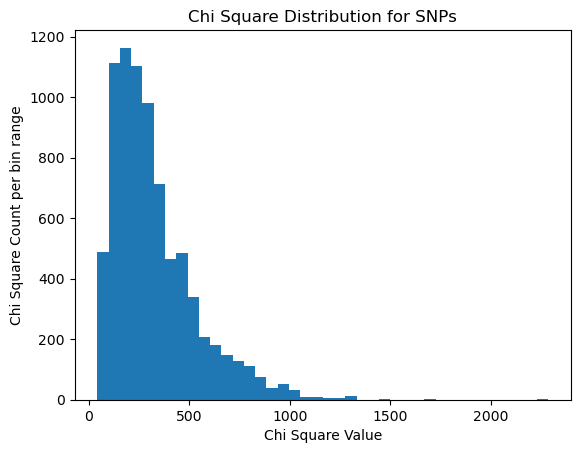

In [12]:
# Sort the list in-place from highest to lowest
# chi2_list.sort(reverse=True)
create_hist(chi2_list)

In [13]:
p99, p95, med, avg = get_95th_percentile_chi2_score(chi2_list)
print("99th Percentile:", p99)
print("95th Percentile:", p95)
print("Median:", med)
print("Average:", avg)

99th Percentile: 979.684695894328
95th Percentile: 744.7276049540396
Median: 269.58909566410097
Average: 321.67550490722556


In [14]:
chi2_distribution, p_value_distribution = get_chi2_for_listOfChi2s(chi2_list)
print("Chi2 distribution score:", chi2_distribution)
print("Distribution P value:", p_value_distribution)

Chi2 distribution score: 1041492.1379983302
Distribution P value: 0.0


# Analysis for single target cancer SNP

In [15]:
# humanID_to_PopulationCode = get_humanID_to_PopulationCode('rawData/igsr_samples.tsv')

In [16]:
snp_file_path, chi2, p_value, single_snp_df = main_single_snp("TargetSNPsData/rs4713266.csv", humanID_to_PopulationCode)

print("SNP File Path:", snp_file_path)
print("Chi2:", chi2)
print("P value:", p_value)

SNP File Path: TargetSNPsData/rs4713266.csv
Chi2: 1016.5887020893715
P value: 2.6643478095338636e-180


In [17]:
superPopulationcode_grouped_single_snp_df = superPopulationDataframes_with_ratios(superPopulationCode_to_populationCodes, single_snp_df)

In [18]:
print_superPopulationCode_to_populationCode_dataframes(superPopulationcode_grouped_single_snp_df)

-------------------------------------------
EUR - European Ancestry
           Reference Heterozygous       ALT
TSI             21.0         53.0      37.0
CEU             21.0         61.0      17.0
IBS             27.0         55.0      25.0
GBR             27.0         53.0      20.0
FIN             39.0         43.0      23.0
Ratio       0.258621     0.507663  0.233716
Percentage    25.86%       50.77%    23.37%
-------------------------------------------
EAS - East Asian Ancestry
           Reference Heterozygous       ALT
JPT              5.0         36.0      64.0
CHB              7.0         29.0      70.0
KHV              6.0         34.0      59.0
CDX             10.0         47.0      43.0
CHS              6.0         34.0      65.0
Ratio       0.066019     0.349515  0.584466
Percentage     6.60%       34.95%    58.45%
-------------------------------------------
AMR - American Ancestry
           Reference Heterozygous       ALT
MXL             14.0         26.0      24.0
PE

# Plotting Cancer SNP Chi2 Score and ALT Frequency on Scatter Plot with other SNPs

In [19]:
single_snp_ALT_frequency = get_ALT_frequency_for_single_snp(single_snp_df)

/Users/toddgavin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/toddgavin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/toddgavin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpr

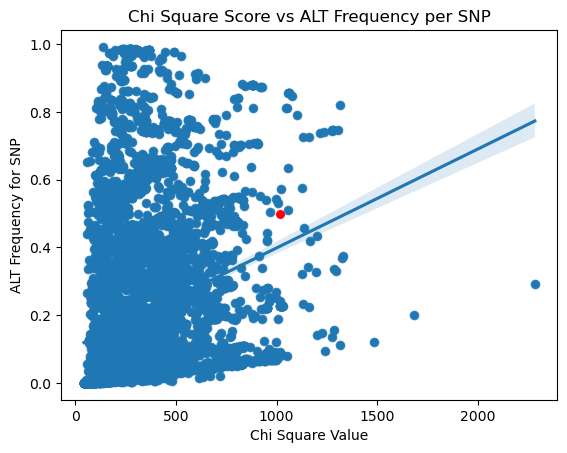

In [20]:
create_scatter_plot_of_chi2s_and_ALTfrequencies(chi2_list, alt_frequency_list, chi2, single_snp_ALT_frequency)

In [21]:
performLinearRegression(chi2_list, alt_frequency_list)

R_value: 0.059568518373666765
P_value: 5.34822698182223e-107


In [28]:
def get_range(totalBases, chr):
    str_range = "chr" + str(chr) + ":"

    parsing_length = totalBases * 0.01

    for i in range(0, int(totalBases), int(parsing_length)):
        str_range += (str(i) + "-" + str(i+250) + ",")

    return str_range

print(get_range(250000000, 1))

chr1:0-250,2500000-2500250,5000000-5000250,7500000-7500250,10000000-10000250,12500000-12500250,15000000-15000250,17500000-17500250,20000000-20000250,22500000-22500250,25000000-25000250,27500000-27500250,30000000-30000250,32500000-32500250,35000000-35000250,37500000-37500250,40000000-40000250,42500000-42500250,45000000-45000250,47500000-47500250,50000000-50000250,52500000-52500250,55000000-55000250,57500000-57500250,60000000-60000250,62500000-62500250,65000000-65000250,67500000-67500250,70000000-70000250,72500000-72500250,75000000-75000250,77500000-77500250,80000000-80000250,82500000-82500250,85000000-85000250,87500000-87500250,90000000-90000250,92500000-92500250,95000000-95000250,97500000-97500250,100000000-100000250,102500000-102500250,105000000-105000250,107500000-107500250,110000000-110000250,112500000-112500250,115000000-115000250,117500000-117500250,120000000-120000250,122500000-122500250,125000000-125000250,127500000-127500250,130000000-130000250,132500000-132500250,135000000-135